1. Скачать видео:
https://www.youtube.com/watch?v=NdSqAAT28v0

In [2]:
import os
!yt-dlp 'https://www.youtube.com/watch?v=NdSqAAT28v0' -o 'video.webm'

[youtube] Extracting URL: https://www.youtube.com/watch?v=NdSqAAT28v0
[youtube] NdSqAAT28v0: Downloading webpage
[youtube] NdSqAAT28v0: Downloading ios player API JSON
[youtube] NdSqAAT28v0: Downloading player 4b63a6a1
[youtube] NdSqAAT28v0: Downloading m3u8 information
[info] NdSqAAT28v0: Downloading 1 format(s): 244+251
[download] Destination: Techno⧸Tech House Mix by DJ Haluk Arslan with Shadow Dancers [NdSqAAT28v0].f244.webm
[download] 100% of  275.72MiB in 00:00:34 at 7.90MiB/s0;33m00:000m
[download] Destination: Techno⧸Tech House Mix by DJ Haluk Arslan with Shadow Dancers [NdSqAAT28v0].f251.webm
[download] 100% of   74.04MiB in 00:00:07 at 9.59MiB/s0;33m00:000m
[Merger] Merging formats into "Techno⧸Tech House Mix by DJ Haluk Arslan with Shadow Dancers [NdSqAAT28v0].webm"
Deleting original file Techno⧸Tech House Mix by DJ Haluk Arslan with Shadow Dancers [NdSqAAT28v0].f251.webm (pass -k to keep)
Deleting original file Techno⧸Tech House Mix by DJ Haluk Arslan with Shadow Dancers [N

2. Средствами библиотек Python извлечь из видео кадры (в оригинале извлекался каждый третий кадр).

In [20]:
import cv2

vidcap = cv2.VideoCapture('video.webm')

In [21]:
import os

os.makedirs('video_frames', exist_ok=True)

frame_margin = 3

success, image = vidcap.read()
count = 1
alt_count = 1
while success:
    if count % frame_margin == 0:
        cv2.imwrite(os.path.join("video_frames", f"image_{alt_count}.jpg"), image)
        alt_count += 1
    success, image = vidcap.read()
    count += 1


3. Средствами библиотек Python преобразовать разрешение кадров 1920x1080 -> 96x54 (можно другое соотношение).

In [22]:
import cv2, os

os.makedirs('video_frames_small', exist_ok=True)

for image_name in os.listdir('video_frames'):
    image = cv2.imread(os.path.join('video_frames', image_name))
    image = cv2.resize(image, (96, 54))
    cv2.imwrite(os.path.join("video_frames_small", image_name), image)

4. Средствами библиотек Python перевести в черно-белое изображение (белый фон, черная фигура)

In [23]:
import cv2, os
import matplotlib.pyplot as plt
import numpy as np

os.makedirs('video_frames_bw', exist_ok=True)
for image_name in os.listdir('video_frames_small'):
    image = cv2.imread(os.path.join('video_frames_small', image_name), 1)
    tmp = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, alpha = cv2.threshold(tmp, 50, 255, cv2.THRESH_BINARY)
    image[alpha.astype(bool), :] = [255, 255, 255]
    cv2.imwrite(os.path.join("video_frames_bw", image_name), image)

5. Обучить в Pytorch автоэнкодер (с помощью полносвязных слоев или, как в видео, сверточных) так, чтобы каждое изображение кодировалось вектором длины 128.

In [24]:
import torch
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
import os
import cv2
import numpy as np

In [25]:

class DanceImageDataset(Dataset):
    def __init__(self, base_path):
        self.base_path = base_path
        self.image_names = os.listdir(base_path)

    def __getitem__(self, index):
        image = cv2.imread(os.path.join(self.base_path, self.image_names[index]), cv2.COLOR_BGR2GRAY)
        one_channel_image = (image[:, :, 1]
                             .reshape(96 * 54)
                             .astype(np.float32))  # так как по факту у нас и так все чб, можно взять один канал
        return one_channel_image, one_channel_image

    def __len__(self):
        return len(self.image_names)


dataset = DanceImageDataset('video_frames_bw')
loader = torch.utils.data.DataLoader(dataset=dataset,
                                     batch_size=1024,
                                     shuffle=True)

In [26]:
# Creating a PyTorch class
# 28*28 ==> 9 ==> 28*28
class AE(torch.nn.Module):
    def __init__(self):
        super().__init__()

        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(96 * 54, 2048),
            torch.nn.ReLU(),
            torch.nn.Linear(2048, 512),
            torch.nn.ReLU(),
            torch.nn.Linear(512, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 128),
        )

        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(128, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 512),
            torch.nn.ReLU(),
            torch.nn.Linear(512, 2048),
            torch.nn.ReLU(),
            torch.nn.Linear(2048, 96 * 54)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


In [27]:
model = AE()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

model.to(device)

loss_function = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),
                             lr=1e-1,
                             weight_decay=1e-8)

cuda


epoch 0 started
epoch 1 started
epoch 2 started
epoch 3 started
epoch 4 started
epoch 5 started
epoch 6 started
epoch 7 started
epoch 8 started
epoch 9 started
epoch 10 started
epoch 11 started
epoch 12 started
epoch 13 started
epoch 14 started
epoch 15 started
epoch 16 started
epoch 17 started
epoch 18 started
epoch 19 started


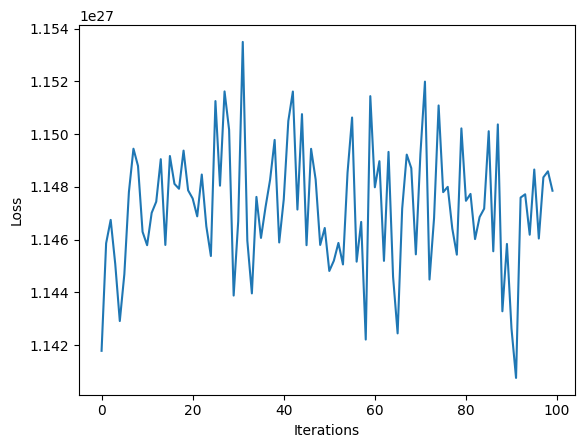

In [28]:
import gc

epochs = 20
losses = []
for epoch in range(epochs):
    print(f'epoch {epoch} started')
    for (image, _) in loader:
        image = image.to(device)
        # Output of Autoencoder
        reconstructed = model(image)

        # Calculating the loss function
        loss = loss_function(reconstructed, image)

        # The gradients are set to zero,
        # the gradient is computed and stored.
        # .step() performs parameter update
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Storing the losses in a list for plotting
        losses.append(loss.cpu().detach())
        # del loss
    torch.cuda.empty_cache()
    # gc.collect()

# Defining the Plot Style
plt.xlabel('Iterations')
plt.ylabel('Loss')

# Plotting the last 100 values
plt.plot(losses[-100:])

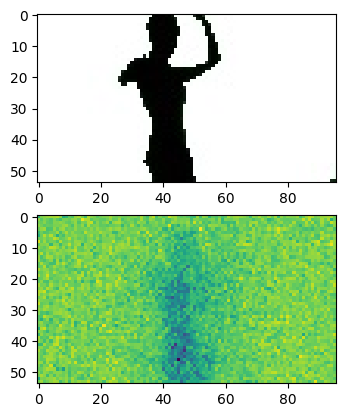

In [35]:
import matplotlib.pyplot as plt

test_image = cv2.imread('video_frames_bw/image_12.jpg')

plt.subplot(2,1,1)
plt.imshow(test_image)

test_img_reshaped = torch.from_numpy(test_image[:,:,1]
                     .reshape(96 * 54)
                     .astype(np.float32)).to(device)
predicted = model(test_img_reshaped)

predicted = predicted.cpu().detach()

plt.subplot(2,1,2)
plt.imshow(predicted.reshape(54,96))


6. Перевести все изображения в последовательность 128-мерных векторов.
7. Обучить рекуррентную нейронную сеть (подобрать параметры самостоятельно) предсказывать по текущему следующий вектор.
8. С помощью обученной сети сгенерировать последовательность векторов.
9. Перевести с помощью декодера последовательность векторов в последовательность кадров.
10. Средствами библиотек Python преобразовать кадры в видео.